## Massage Data (Relabeling) Preprocessing Algorithm on UCI Adult Dataset

### Dataset/Model Bias Check and Mitigation by Massage Data

### Table of contents :
1. [Introduction](#1.-Introduction)
2. [Data preparation](#2.-Data-Preparation)
3. [Fairness Before Debiasing](#3.-Fairness-Before-Debiasing)
    * 3.1 [Bias In The Data](#3.1-Bias-In-The-Data)
    * 3.2 [Bias In The Model](#3.2-Bias-In-The-Model)
4. [Massage Data Preprocessing Algorithm](#4.-Massage-Data-Preprocessing-Algorithm)
5. [Fairness After Debiasing](#5.-Fairness-After-Debiasing)
    * 5.1 [Bias In The Data](#5.1-Bias-In-The-Data)
    * 5.2 [Bias In The Model](#5.2-Bias-In-The-Model)
6. [Fairness Comparission (Orignial vs Mitigated)](#6.-Fairness-Comparission-(Orignial-vs-Mitigated)) 
    * 6.1 [Data Fairness](#6.1-Data-Fairness)
    * 6.2 [Model Fairness](#6.2-Model-Fairness)
7. [Summary](#7.-Summary)
8. [References](#8.-References)

### 1. Introduction

Welcome to this tutorial notebook on the Massage Data Preprocessing(Relabeling) Algorithm.

In the previous Sony Fairness AI tutorial, we discussed the `Reweighing` preprocessing technique to mitigate the bias in the dataset by using the rewiging sample weights. In this tutorial, we will discuss a new preprocessing technique called the `Massage Data Preprocessing Algorithm` that can be used to reduce discrimination in datasets while maintaining the overall class distribution. Discrimination in datasets can often arise due to factors such as class imbalance or outlier data points. We will cover the key concepts of the algorithm and provide step-by-step instructions on how to implement it on the UCI Adult dataset. This includes identifying promotion and demotion candidates and training a ranker to sort objects by their positive class probability.

Before we go into detailed explanation, here is a sneak peek into the steps involved in the process


In [1]:
# Preparation
!git clone https://github.com/sony/nnabla-examples.git
%cd nnabla-examples/responsible_ai/massage_data

import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread('images/massage_data_workflow_diagram.png')
cv2_imshow(img)

Let's get import the necessary python packages

In [2]:
import sys
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,confusion_matrix,roc_curve, auc
sys.path.append('../responsible_ai/massage_data')
from utils import *

### 2. Data Preparation
Download and parse the UCI Adult dataset as a pandas dataframe

In [3]:
train_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
test_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
              'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
              'hours-per-week', 'native-country', 'income']
train_samples = pd.read_csv(train_url,names=column_names,na_values="?", sep=r'\s*,\s*', engine='python')
num_train = len(train_samples)
test_samples = pd.read_csv(test_url,names=column_names, na_values="?", sep=r'\s*,\s*', engine='python', skiprows=1)
df = pd.concat([train_samples,test_samples])

let's preprocess and split the `UCI Adult` dataset to check for any gender bias in the data. In this analysis, the `sex` attribute will be considered as the `sensitive attribute`, and the `income` attribute will be treated as the `target attribute`. 

In [4]:
# select target attribute
target_attribute = "income"
df[target_attribute] = ((df[target_attribute] == '>50K') | (df[target_attribute] == '>50K.')).astype(int)
positive_class = 1
negative_class= 0

# select senstive attribute 
sensitive_attribute = "sex"
privileged_class = 1 # Male
unprivileged_class = 0 # Female
df[sensitive_attribute] = df[sensitive_attribute].map({'Male': 1, 'Female': 0})

# one-hot encoding
df = pd.get_dummies(df, columns=["workclass", "education", "marital-status",
                                 "occupation", "relationship", "race", "native-country"])
train_samples = df[:num_train].copy()
test_samples = df[num_train:].copy()

### 3. Fairness Before Debiasing


#### 3.1 Bias In The Data

Now will check the data bias in the dataset using `Statistical Parity Difference` and `Disparate Impact` metrics before model training. For those who are unfamiliar with these metrics, please refer to our Gender Bias Mitigation and Four Metrics Tutorial Notebook for more information.

In [5]:
# split the features and labels for both train and test data
feature_names = [n for n in train_samples.columns if n not in target_attribute]
X_train, X_test, Y_train, Y_test, Z_train, Z_test = train_samples[feature_names].copy(), test_samples[
    feature_names].copy(), train_samples[target_attribute].to_frame().copy(), test_samples[target_attribute].to_frame().copy(),train_samples[sensitive_attribute].to_frame().copy(),test_samples[sensitive_attribute].to_frame().copy()

In [6]:
dpd_before_debiasing = statistical_parity_difference(X_train,Y_train,target_attribute,positive_class,sensitive_attribute,privileged_class,unprivileged_class)
di_before_debiasing = disparate_impact(X_train,Y_train,target_attribute,positive_class,sensitive_attribute,privileged_class,unprivileged_class)

In [7]:
print(f"Before Data debiasing : DPD {abs(dpd_before_debiasing)} Disparate Impact : {abs(di_before_debiasing)}" )

Before Data debiasing : DPD 0.19627598779361352 Disparate Impact : 0.3580225496813511


#### 3.2 Bias In The Model

Here in this tutorial we have trained multiple classifiers to evaluate their performance and fairness before and after debiasing the dataset with the Massage Data Preprocessing Algorithm. To keep it simple and facilitate understanding, we have included only the Logistic Regression, GradientBoostingClassifier, Random Forest Classifier, and XGB Classifier in the models list. However, you can add your preferred models to the list and run the experiment accordingly.

In [8]:
models = []
models.append(('LR', LogisticRegression(max_iter=500,random_state=42)))
models.append(('GBC', GradientBoostingClassifier(random_state=42)))
models.append(('RF', RandomForestClassifier(random_state=42)))
models.append(('XGB', xgb.XGBClassifier(eval_metric='mlogloss',use_label_encoder=False)))

Let's standardize the dataset before training the model

In [9]:
scale_orig = StandardScaler()
S_train = scale_orig.fit_transform(X_train)
S_test = scale_orig.fit_transform(X_test)

As the next step, we will train all the models using the original dataset and evaluate their performance and fairness. We will compute the fairness metrics, including `Demographic Parity Difference (DPD)`, `Disparate Impact (DI)`, `Equal Opportunity Difference (EOD)`, and `Equalized Odds (AAOD)`, using the `get_model_fairness` function. Additionally, to evaluate the model performance, we will compute the `Accuracy` and `ROC-AUC` metrics.

In [10]:
models_names, dpd_list, di_list, eod_list, aaod_list, accuracy_list, roc_auc_list, preds_prob = [], [], [], [], [], [], [], []
for name, model in models:
    clf = train_model(model, S_train, Y_train.values.ravel())
    y_score = clf.predict_proba(S_test)[:, 1]
    preds = (y_score > 0.5).astype(int)
    accuracy = accuracy_score(Y_test, preds)
    fpr, tpr, _ = roc_curve(Y_test, preds)
    roc_auc = auc(fpr, tpr)
    
    DPD, DI, EOD,AAOD = get_model_fairness(Y_test,Z_test[sensitive_attribute]==privileged_class,preds)
    dpd_list.append(abs(DPD))
    di_list.append(abs(DI))
    eod_list.append(abs(EOD))
    aaod_list.append(abs(AAOD))
    accuracy_list.append(accuracy)
    preds_prob.append(y_score)
    roc_auc_list.append(roc_auc)
    models_names.append(name)
    print(f"Model : {name} accuracy : {round(accuracy,2)} DPD : {abs(round(DPD,3))} ,DI : {abs(round(DI,3))}, EOD : {abs(round(EOD,3))} , AAOD : {abs(round(AAOD,3))}")

Model : LR accuracy : 0.85 DPD : 0.177 ,DI : 0.307, EOD : 0.082 , AAOD : 0.08
Model : GBC accuracy : 0.87 DPD : 0.159 ,DI : 0.31, EOD : 0.078 , AAOD : 0.066
Model : RF accuracy : 0.85 DPD : 0.172 ,DI : 0.32, EOD : 0.065 , AAOD : 0.071
Model : XGB accuracy : 0.87 DPD : 0.173 ,DI : 0.318, EOD : 0.076 , AAOD : 0.071


Let's compute the performance of all the models by plotting their ROC AUC curves

Based on the above fairness metrics, it is evident that there is bias towards the gender attribute, favoring one of the groups. To address this issue, we will use the Massage Data Preprocessing algorithm to mitigate the bias.

To facilitate comparison of model performance and fairness, we will store all the relevant values in a dictionary

In [11]:
before_debiasing = defaultdict(dict)
before_debiasing["Accuracy"] = accuracy_list
before_debiasing["DPD"] = dpd_list
before_debiasing["DI"] = di_list
before_debiasing["EOD"] = eod_list
before_debiasing["AAOD"] = aaod_list
before_debiasing["AUC"] = roc_auc_list

### 4. Massage Data Preprocessing Algorithm

To provide an overview of how the Massage Data algorithm works to mitigate bias in a dataset, let's first understand its purpose. As mentioned earlier in the  introduction, It's pre-processing technique that modifies the class labels of certain objects in a strategic manner, with the aim of reducing discrimination while preserving the overall class distribution in a dataset. This is done by selectively promoting or demoting objects, which are then relabeled to achieve greater fairness in the dataset.

Promotion candidates are objects that belong to the sensitive group (For Ex: female candidates in a job recruitment dataset) and were assigned the negative class label (For Ex; not hired). Demotion candidates, on the other hand, are objects that belong to the non-sensitive group (For Ex: male candidates) and were assigned the positive class label (For Ex: hired).

To identify the promotion and demotion candidates, a ranker is trained to sort objects by their positive class probability. This allows the promotion candidates to be sorted in descending order, while the demotion candidates are sorted in ascending order. This ranking strategy ensures that objects closest to the decision boundary are targeted first for relabeling, which minimizes the impact on the overall accuracy of the dataset.  now let's implement the ranker algorithm to identify the promotion and demotion list. 

In [12]:
def get_pr_dem(x_train,y_train,z_train,sensitive_attribute, sensitive_class,target_attribute,desired_class):
    # Create a ranker model to get promotion and demotion 
    ranker = RandomForestClassifier(random_state=42)
    # Fit the ranker model using the dataset D
    ranker.fit(x_train, y_train.values.ravel())
    pr = x_train[(z_train[sensitive_attribute] == sensitive_class) & (y_train[target_attribute] != desired_class)].copy()
    dem = x_train[(z_train[sensitive_attribute] != sensitive_class) & (y_train[target_attribute] == desired_class)].copy()
    pr["score"] = ranker.predict_proba(pr)[:,1]
    pr = pr.sort_values("score", ascending=False)
    dem["score"] = ranker.predict_proba(dem)[:,1]
    dem = dem.sort_values("score", ascending=True)
    return pr, dem

To achieve a discrimination-free dataset, we need to calculate the number of pairs of promotions and demotions that need to be modified. The formula to achieve zero discrimination is given below.

$disc_{S=b}(D) := \frac{\left|\{X \in D | X(S) = w, X(Class) = +\}\right|}{\left|\{X \in D | X(S) = w\}\right|} - \frac{\left|\{X \in D | X(S) = b, X(Class) = +\}\right|}{\left|\{X \in D | X(S) = b\}\right|}$,
$M = \text{disc}(D) \times \frac{|D_b| \times |D_w|}{|D|}$

In the above formula, the dataset is denoted by D, and S represents the sensitive attribute, b and w denotes the deprived and favored communities respectively and the superscript + represents the desired class.

To select the promotion and demotion candidates in the Massage Data algorithm, the top M objects from the promotion and demotion list are chosen. This method ensures that objects closest to the decision border are relabeled first, which minimizes the impact on the overall accuracy of the model. now let's implement the Massage Data Algorithm

In [13]:
def get_massaged_data(x_train,y_train,z_train, sensitive_attribute,sensitive_class,target_attribute,positive_class=1, negative_class=0):
    
    # Get the promotion and demotion lists
    pr, dem = get_pr_dem(x_train,y_train,z_train, sensitive_attribute, sensitive_class, target_attribute, positive_class)
    
    count_b_positive = len (x_train[(z_train[sensitive_attribute] == sensitive_class) & (y_train[target_attribute] == positive_class)])
    count_b = len(x_train[(z_train[sensitive_attribute] == sensitive_class)])
    
    count_w_positive = len(x_train[(z_train[sensitive_attribute] != sensitive_class) & (y_train[target_attribute] == positive_class)])
    count_w = len(x_train[(z_train[sensitive_attribute] != sensitive_class)])
    
    # Way to calculate M
    
    discS_b = abs((count_w_positive / count_w) - (count_b_positive / count_b))
    di = ((count_b_positive / count_b) / (count_w_positive / count_w))
    M = int((discS_b * count_w * count_b)/len(x_train))
    
    print ("Discrimination M(Relabeled) :",M)
    # change Top M objects of pr and dem
    pr = pr[:M]
    pr[target_attribute] = positive_class
    dem = dem[:M]
    dem[target_attribute] = negative_class
    
    y_train.loc[pr.index, target_attribute] = positive_class
    y_train.loc[dem.index, target_attribute] = negative_class

Now that we have implemented the Massage Data Algorithm, we will apply it on the UCI Adult Dataset and examine if the fairness of the data and model has improved in comparison to the original model.

In [14]:
get_massaged_data(X_train,Y_train,Z_train, sensitive_attribute, unprivileged_class, target_attribute,positive_class)

Discrimination M(Relabeled) : 1414


### 5. Fairness After Debiasing

#### 5.1 Bias In The Data

In [15]:
dpd_after_debiasing = statistical_parity_difference(X_train,Y_train,target_attribute,positive_class,sensitive_attribute,privileged_class,unprivileged_class)
di_after_debiasing = disparate_impact(X_train,Y_train,target_attribute,positive_class,sensitive_attribute,privileged_class,unprivileged_class)
print(f"After Data debiasing : DPD {abs(dpd_after_debiasing)} Disparate Impact : {abs(di_after_debiasing)}" )

After Data debiasing : DPD 0.00010540260125166401 Disparate Impact : 0.9995623622939646


#### 5.2 Bias In The Model
let's train the model with the relabelled target attribute

In [16]:
# y_train = train_samples[target_attribute].values.copy()

In [17]:
models_names, dpd_list, di_list, eod_list, aaod_list, accuracy_list, roc_auc_list, preds_prob = [], [], [], [], [], [], [], []
for name, model in models:
    clf = train_model(model, S_train, Y_train.values.ravel())
    y_score = clf.predict_proba(S_test)[:, 1]
    preds = (y_score > 0.5).astype(int)
    accuracy = accuracy_score(Y_test, preds)
    fpr, tpr, _ = roc_curve(Y_test, preds)
    roc_auc = auc(fpr, tpr)
    
    DPD, DI, EOD,AAOD = get_model_fairness(Y_test,Z_test[sensitive_attribute]==privileged_class,preds)
    dpd_list.append(abs(DPD))
    di_list.append(abs(DI))
    eod_list.append(abs(EOD))
    aaod_list.append(abs(AAOD))
    accuracy_list.append(accuracy)
    preds_prob.append(y_score)
    roc_auc_list.append(roc_auc)
    models_names.append(name)
    print(f"Model : {name} accuracy : {round(accuracy,2)} DPD : {abs(round(DPD,3))} ,DI : {abs(round(DI,3))}, EOD : {abs(round(EOD,3))} , AAOD : {abs(round(AAOD,3))}")

Model : LR accuracy : 0.83 DPD : 0.002 ,DI : 1.009, EOD : 0.302 , AAOD : 0.183
Model : GBC accuracy : 0.84 DPD : 0.007 ,DI : 1.035, EOD : 0.298 , AAOD : 0.186
Model : RF accuracy : 0.83 DPD : 0.013 ,DI : 0.94, EOD : 0.275 , AAOD : 0.165
Model : XGB accuracy : 0.84 DPD : 0.01 ,DI : 1.049, EOD : 0.3 , AAOD : 0.191


To facilitate comparison of model performance and fairness, we will store all the relevant values in a dictionary

In [18]:
after_debiasing = defaultdict(dict)
after_debiasing["Accuracy"] = accuracy_list
after_debiasing["DPD"] = dpd_list
after_debiasing["DI"] = di_list
after_debiasing["EOD"] = eod_list
after_debiasing["AAOD"] = aaod_list
after_debiasing["AUC"] = roc_auc_list

Now that we have all the data, let's plot and compare the bias of the original and modified datasets to determine if the fairness of the dataset and model has improved or not.

### 6. Fairness Comparission (Orignial vs Mitigated)

#### 6.1 Data Fairness

compare the statistical parity difference(demogrpahic parity) of original and relabelled dataset. 

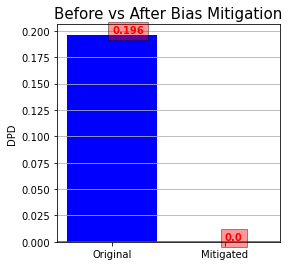

In [19]:
plot_fairness_comp(abs(dpd_before_debiasing),abs(dpd_after_debiasing))

As you observe the above plots, the initial value of `statistical parity difference` was `0.19`(Original). However, after applying the Massage Data Algorithm, the fairness improved and reached `0.0`(Mitigated). This indicates that the fairness of the dataset has improved significantly with respect to this metric. same let's plot for the `Disparate Impact`.

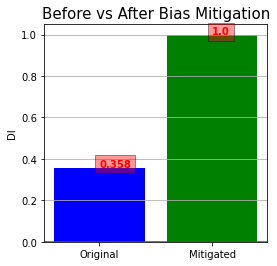

In [20]:
plot_fairness_comp(abs(di_before_debiasing),abs(di_after_debiasing),metric = "DI")

The initial value of `Disparate Impact` was `0.35`(original), After applying the Massage Data Algorithm, the fairness improved and reached `1.0`(Mitigated). This indicates that the fairness of the dataset has improved significantly with respect to this metric. same let's plot for `Disparate Impact`. Now let's compare Model Performance and Fairness.

#### 6.2 Model Performance & Fairness

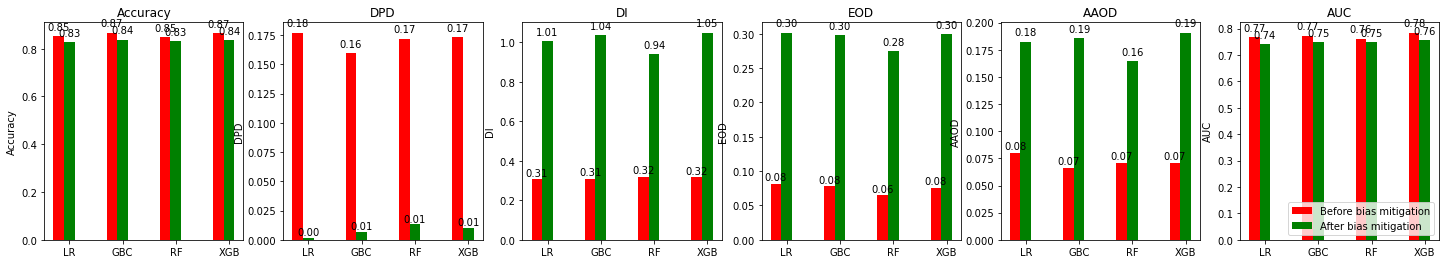

In [21]:
def autolabel(rects, axes):
        for rect in rects:
            h = rect.get_height()
            if h < 0:
                axes.text(rect.get_x() + rect.get_width() / 2., h - 0.04, '%.2f' % float(h),
                          ha='center', va='bottom')
            else:
                axes.text(rect.get_x() + rect.get_width() / 2., 1.02 * h, '%.2f' % float(h),
                          ha='center', va='bottom')
ind = np.arange(len(models_names))  # the x locations for the groups
width = 0.2  # the width of the bars

fig, axs = plt.subplots(1, 6, figsize=(25, 4))

for ax,metric in zip (axs.ravel(),after_debiasing.keys()):
    fairness_base_bar = ax.bar(ind, before_debiasing[metric], width, color='r',
                        label='Before bias mitigation')
    fairness_mitigated_bar = ax.bar(ind + width, after_debiasing[metric], width, color='g',
                                     label='After bias mitigation')
    ax.set_ylabel(metric)
    ax.set_xticks(ind + width)
    ax.set_xticklabels(models_names)
    ax.title.set_text(metric)
    autolabel(fairness_base_bar, axes=ax)
    autolabel(fairness_mitigated_bar, axes=ax)
plt.legend(loc ="lower right")
plt.show()

Based on the above plots, After applying the `Massage Data Algorithm` on the `UCI Adult Dataset`, there was a slight drop in accuracy and ROC-AUC, but it improved the fairness of the dataset with respect to Demographic Parity and Disparate Impact. However, the Equal Opportunity Difference and Equalised Odds fairness metrics have dropped, possibly due to too many adjusted labels. If we can minimise the number of adjusted labels, the fairness of the models will improve for other fairness metrics as well. In a separate tutorial, the Massage Data algorithm was applied to the `UCI German Credit Dataset`, where fairness was improved for all criteria.

### 7. Summary

The Massage Data Algorithm is a fair data preprocessing technique used to mitigate discrimination in machine learning models. This algorithm operates on labeled datasets and adjusts the labels of sensitive attributes to achieve fairness. In this tutorial, we applied the algorithm on the UCI Adult dataset and observed improved fairness in some metrics while others were affected due to a large number of adjusted labels as we discussed we can minimise the number of adjusted labels, the fairness of the models will improve for other fairness metrics as well . The algorithm useful for ensuring fairness in machine learning models.

### 8. References

1. Kamiran, Faisal, and Toon Calders. "Data preprocessing techniques for classification without discrimination." Knowledge and information systems 33, no. 1 (2012): 1-33.
2. [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/adult)